# Ames, Iowa : Predicting Sales Prices - Penalized Linear Regression Modeling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler,\
MinMaxScaler, MaxAbsScaler, FunctionTransformer, PowerTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from LR_helper import cat_column_combine_vars, num_new_features,\
label_encode_features, model_results, cat_new_features, std_num_cols
from yellowbrick.regressor import PredictionError, ResidualsPlot
from statsmodels.stats.diagnostic import normal_ad
from clean_helper import dtype_update
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

### Loading cleaned training and testing datasets:-

In [2]:
train_df = pd.read_csv("clean_train.csv",index_col=0)
test_df = pd.read_csv("clean_test.csv",index_col=0)
print(train_df.shape)
print(test_df.shape)

(1453, 80)
(1457, 79)


- Creating copies to apply diffrent transformations and engineering techniques:

In [3]:
train_df_cpy = train_df.copy()
test_df_cpy = test_df.copy()
print(train_df_cpy.shape)
print(test_df_cpy.shape)

(1453, 80)
(1457, 79)


### Creating new numerical variables, combining variables and creating new categorical variables:-

In [4]:
# Creating new numerical variable features:-
num_new_features(train_df)
num_new_features(test_df)
num_new_features(train_df_cpy)
num_new_features(test_df_cpy)

# Combining categories in some categorical features:-
cat_column_combine_vars(train_df)
cat_column_combine_vars(test_df)
cat_column_combine_vars(train_df_cpy)
cat_column_combine_vars(test_df_cpy)

# Creating new categorical variable features:-
cat_new_features(train_df)
cat_new_features(test_df)
cat_new_features(train_df_cpy)
cat_new_features(test_df_cpy)

In [5]:
print(train_df.shape)
print(test_df.shape)
print(train_df_cpy.shape)
print(test_df_cpy.shape)

(1453, 88)
(1457, 87)
(1453, 88)
(1457, 87)


### In-depth EDA to research relationship with Sales Price

#### 1. Finished Basement relation to Sale Prices

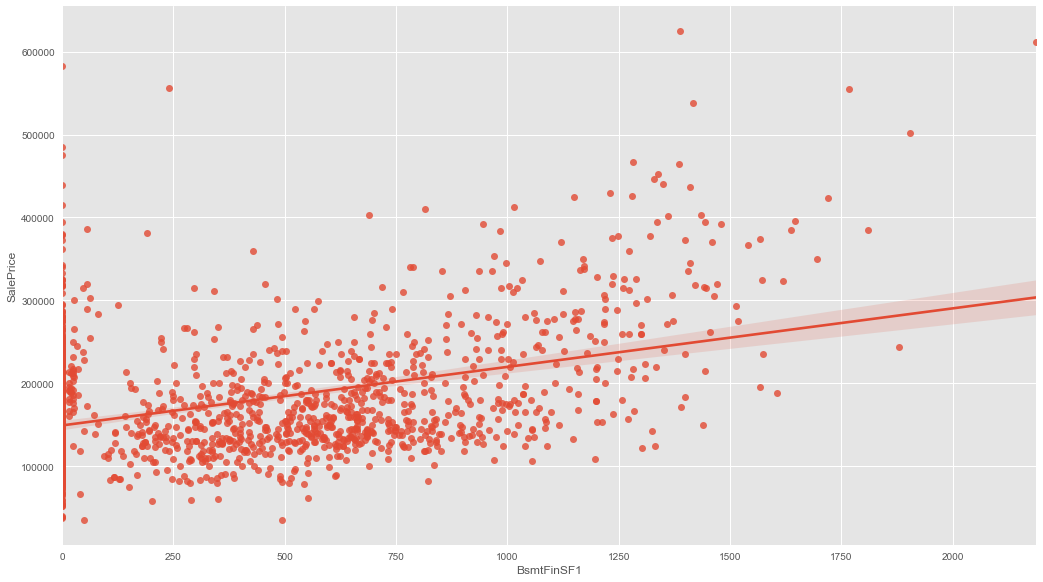

In [6]:
sns.lmplot("BsmtFinSF1", "SalePrice", train_df, height=8, aspect=1.8, palette="Set2")

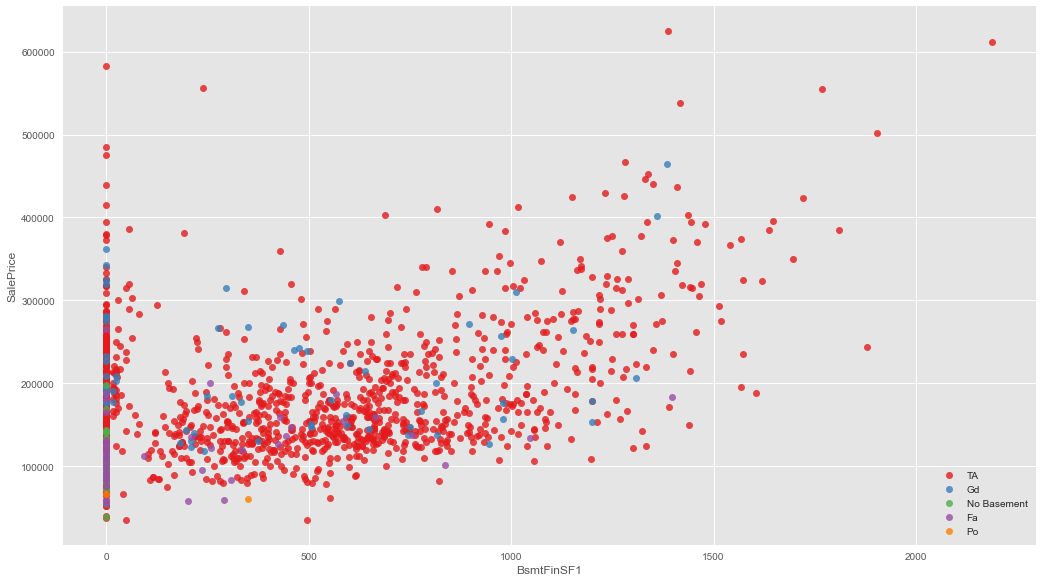

In [7]:
sns.lmplot("BsmtFinSF1", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='BsmtCond', legend=False)
plt.legend(loc='lower right')

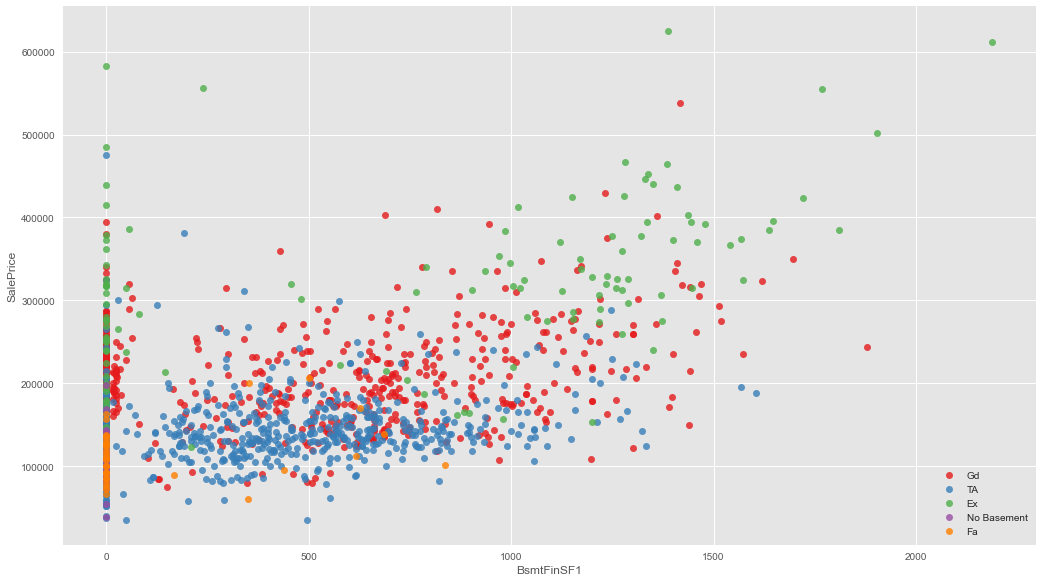

In [8]:
sns.lmplot("BsmtFinSF1", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='BsmtQual', legend=False)
plt.legend(loc='lower right')

#### 2. Above ground living area

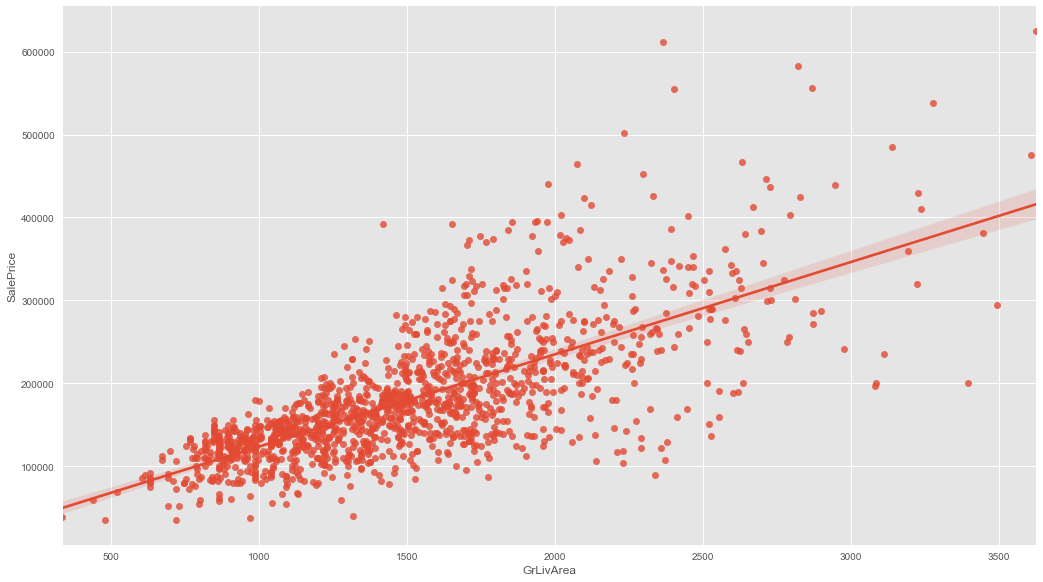

In [9]:
sns.lmplot("GrLivArea", "SalePrice", train_df, height=8, aspect=1.8, palette="Set2")

Text(-12.950000000000006, 0.5, 'Sales Price (USD)')

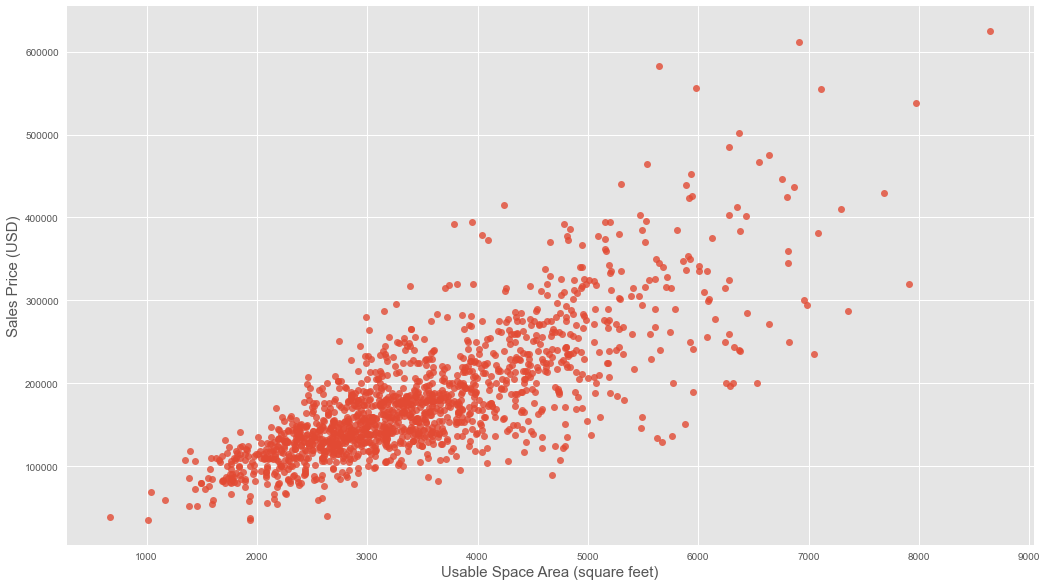

In [10]:
sns.lmplot("Usable_Space", "SalePrice", train_df, height=8, aspect=1.8, fit_reg=False, palette="Set2")
plt.xlabel("Usable Space Area (square feet)", fontsize = 15)
plt.ylabel("Sales Price (USD)", fontsize = 15)

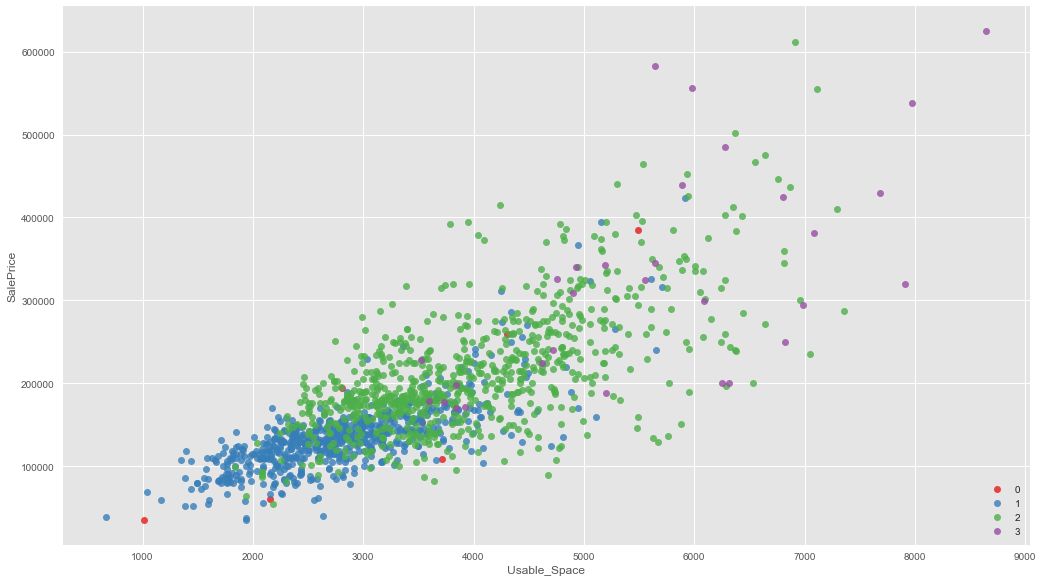

In [11]:
sns.lmplot("Usable_Space", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='FullBath', legend=False)
plt.legend(loc='lower right')

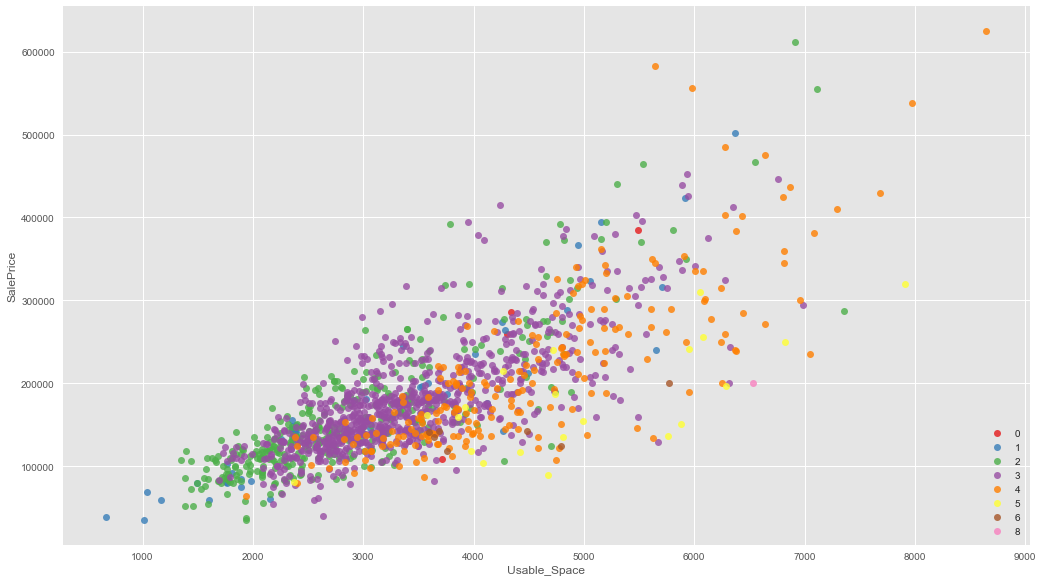

In [12]:
sns.lmplot("Usable_Space", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='BedroomAbvGr', legend=False)
plt.legend(loc='lower right')

#### 4. Years since remodeled and remodeled or not

Text(-12.950000000000006, 0.5, 'Sales Price (USD)')

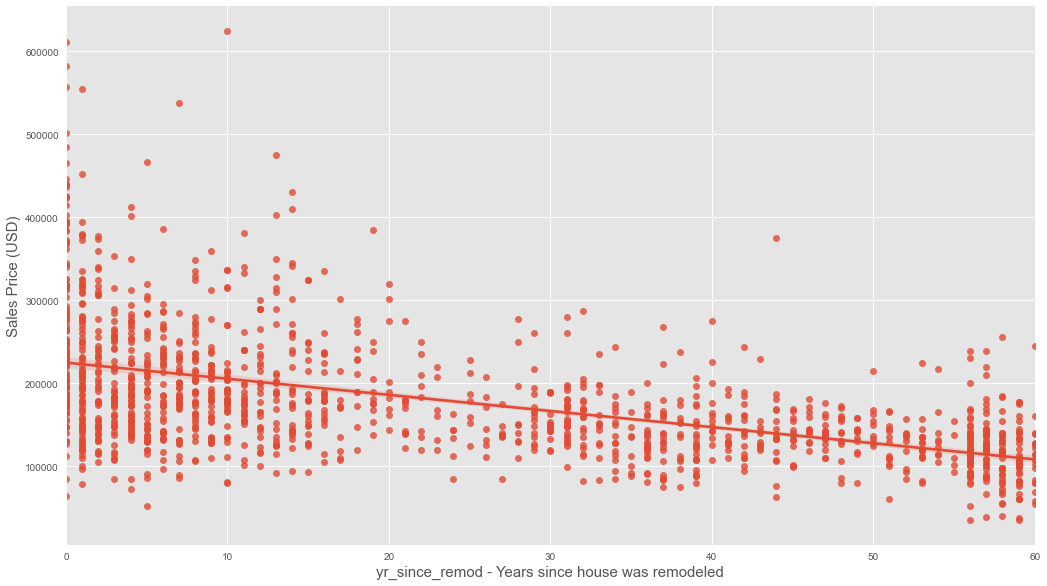

In [13]:
sns.lmplot("yr_since_remod", "SalePrice", train_df, height=8, aspect=1.8, palette="Pastel1")
plt.xlabel("yr_since_remod - Years since house was remodeled", fontsize = 15)
plt.ylabel("Sales Price (USD)", fontsize = 15)

Text(0.5, 1.0, 'House Price vs Years Since Remodeled')

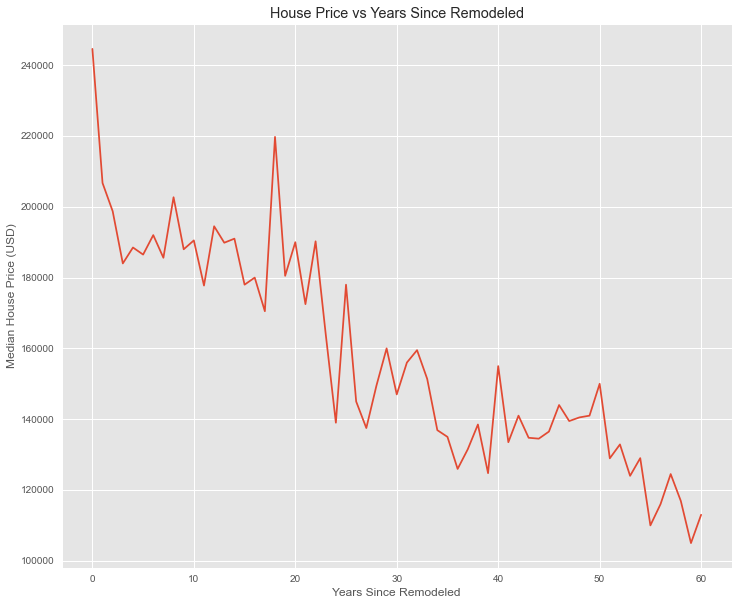

In [14]:
plt.figure(figsize = (12,10))
train_df.groupby('yr_since_remod')['SalePrice'].median().plot()
plt.xlabel('Years Since Remodeled')
plt.ylabel('Median House Price (USD)')
plt.title("House Price vs Years Since Remodeled")

<AxesSubplot:xlabel='remod_y_n', ylabel='SalePrice'>

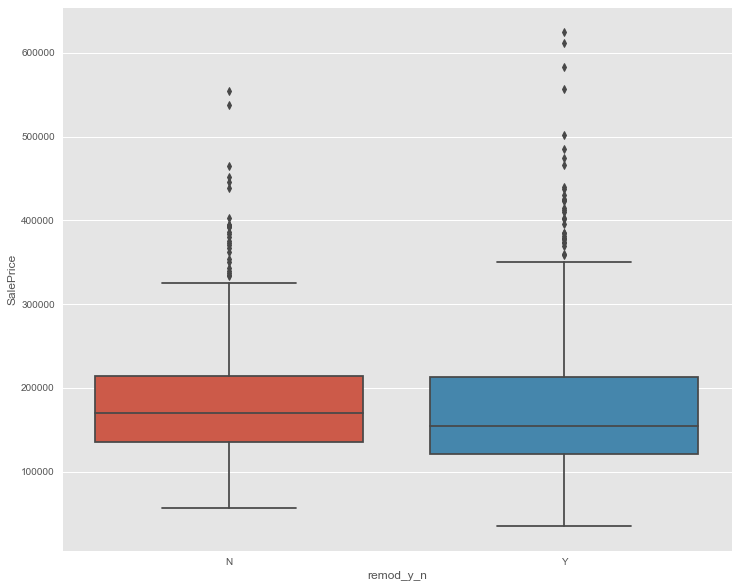

In [15]:
plt.figure(figsize = (12,10))
my_order = train_df.groupby('remod_y_n')['SalePrice']\
           .median().sort_values(ascending=False).index
sns.boxplot(data=train_df, x='remod_y_n', y='SalePrice', order=my_order)

In [16]:
# Dropping some features with high multi-collinearity

train_df = train_df.drop(['RoofStyle','Exterior1st','Exterior2nd','GarageType',\
                          'HouseStyle', 'MSSubClass','MSZoning','MasVnrType'], axis=1)

test_df = test_df.drop(['RoofStyle','Exterior1st','Exterior2nd','GarageType',\
                          'HouseStyle', 'MSSubClass','MSZoning','MasVnrType'], axis=1)

train_df_cpy = train_df_cpy.drop(['RoofStyle','Exterior1st','Exterior2nd','GarageType',\
                          'HouseStyle', 'MSSubClass','MSZoning','MasVnrType'], axis=1)

test_df_cpy = test_df_cpy.drop(['RoofStyle','Exterior1st','Exterior2nd','GarageType',\
                          'HouseStyle', 'MSSubClass','MSZoning','MasVnrType'], axis=1)

### Label encoding categorical features (all dataframes):

In [17]:
#Label encoding via helper functions:-

label_encode_features(train_df)
label_encode_features(test_df)
label_encode_features(train_df_cpy)
label_encode_features(test_df_cpy)

### OneHot encoding categorical features (all dataframes):

In [18]:
col_list = ['Street', 'Alley', 'LandContour','Condition1', 'Condition2',\
            'Utilities', 'LotConfig','Neighborhood', 'GarageYrBlt',\
            'BldgType', 'YearBuilt', 'YearRemodAdd', 'RoofMatl', 'Foundation',\
            'CentralAir','Heating', 'Electrical', 'Functional','YrSold',\
            'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature', 'MoSold', \
            'SaleType', 'SaleCondition','remod_y_n']

train_df = pd.get_dummies(data=train_df, columns=col_list, drop_first=True)
test_df = pd.get_dummies(data=test_df, columns=col_list, drop_first=True)

train_df_cpy = pd.get_dummies(data=train_df_cpy, columns=col_list, drop_first=True)
test_df_cpy = pd.get_dummies(data=test_df_cpy, columns=col_list, drop_first=True)

### Standardizing numerical columns:

- Only for the copies of test and train dfs

In [19]:
std_num_cols(train_df_cpy)
std_num_cols(test_df_cpy)

## Ridge Regression Models:-

In [20]:
## Separating x and y variables for test-train split (main df)

house_x = train_df.drop(['SalePrice'], axis=1)
house_y = train_df['SalePrice']

## Separating x and y variables for test-train split (copy df)

house_x_cpy = train_df_cpy.drop(['SalePrice'], axis=1)
house_y_cpy = train_df_cpy['SalePrice']

# Train test 70:30 split

trainX, testX, trainY, testY = train_test_split(house_x, house_y, random_state=42, test_size=0.3)
trainXcp, testXcp, trainYcp, testYcp = train_test_split(house_x_cpy, house_y_cpy, random_state=42, test_size=0.3)

### 1. Adjusting standardization/normalisation and alpha levels

In [21]:
# Numerical columns standardized:

ridge_base12 = Ridge()
model_results(trainXcp, trainYcp, testXcp, testYcp, ridge_base12, show = True)

Train R^2 is equal to 0.946
Test R^2 is equal to 0.877
The intercept is -97841.313
RSS is equal to 335720542876.312
Train RMSE is equal to 18168.894
Test RMSE is equal to 25670.177
The training error is: 0.05404
The test     error is: 0.12309


[0.054038649846825715, 0.1230940788022602]

In [22]:
# Numerical columns not standardized (normalization is not turned on):

ridge_base11 = Ridge()
model_results(trainX, trainY, testX, testY, ridge_base11, show = True)

Train R^2 is equal to 0.946
Test R^2 is equal to 0.877
The intercept is -97841.313
RSS is equal to 335720542876.312
Train RMSE is equal to 18168.894
Test RMSE is equal to 25670.177
The training error is: 0.05404
The test     error is: 0.12309


[0.054038649846825715, 0.1230940788022602]

In [23]:
# Numerical columns not standardized (normalization is turned on):

ridge_base13 = Ridge()
ridge_base13.set_params(normalize=True)
model_results(trainX, trainY, testX, testY, ridge_base13, show = True)

Train R^2 is equal to 0.914
Test R^2 is equal to 0.885
The intercept is 14295.385
RSS is equal to 532338738138.561
Train RMSE is equal to 22878.817
Test RMSE is equal to 24788.811
The training error is: 0.08569
The test     error is: 0.11479


[0.08568694195388926, 0.11478650428395842]

In [24]:
# Numerical columns not standardized (normalization is turned on and alpha set to 0):

ridge_base14 = Ridge()
ridge_base14.set_params(alpha = 0, normalize=True)
model_results(trainX, trainY, testX, testY, ridge_base14, show = True)

Train R^2 is equal to 0.950
Test R^2 is equal to -323454092875873241792512.000
The intercept is -222896591188807168.000
RSS is equal to 309087089278.000
Train RMSE is equal to 17433.314
Test RMSE is equal to 41611809415801728.000
The training error is: 0.04975
The test     error is: 323454092875873241792512.00000


[0.04975164416978228, 3.2345409287587324e+23]

### 2. Log-transforming y variable only:

In [25]:
# Numerical columns standardized:

ridge_base22 = Ridge()
model_results(trainXcp, np.log(trainYcp), testXcp, np.log(testYcp), ridge_base22, show = True)

Train R^2 is equal to 0.958
Test R^2 is equal to 0.889
The intercept is 10.198
RSS is equal to 6.859
Train RMSE is equal to 0.082
Test RMSE is equal to 0.130
The training error is: 0.04240
The test     error is: 0.11140


[0.042397440964087485, 0.11139892476331859]

In [26]:
# Numerical columns not standardized (normalization is not turned on):

ridge_base21 = Ridge()
model_results(trainX, np.log(trainY), testX, np.log(testY), ridge_base21, show = True)

Train R^2 is equal to 0.958
Test R^2 is equal to 0.889
The intercept is 10.198
RSS is equal to 6.859
Train RMSE is equal to 0.082
Test RMSE is equal to 0.130
The training error is: 0.04240
The test     error is: 0.11140


[0.042397440964087485, 0.11139892476331859]

In [27]:
# Numerical columns not standardized (normalization is turned on):

ridge_base23 = Ridge()
ridge_base23.set_params(normalize=True)
model_results(trainX, np.log(trainY), testX, np.log(testY), ridge_base23, show = True)

Train R^2 is equal to 0.928
Test R^2 is equal to 0.897
The intercept is 10.945
RSS is equal to 11.573
Train RMSE is equal to 0.107
Test RMSE is equal to 0.125
The training error is: 0.07153
The test     error is: 0.10336


[0.07153183345784853, 0.1033589896729703]

In [28]:
# Numerical columns not standardized (normalization is turned on and alpha set to 0):

ridge_base24 = Ridge()
ridge_base24.set_params(alpha = 0, normalize=True)
model_results(trainX, np.log(trainY), testX, np.log(testY), ridge_base24, show = True)

Train R^2 is equal to 0.963
Test R^2 is equal to -373823699339215047229440.000
The intercept is -1275955346820.140
RSS is equal to 6.061
Train RMSE is equal to 0.077
Test RMSE is equal to 238203780651.002
The training error is: 0.03747
The test     error is: 373823699339215047229440.00000


[0.037465301529144845, 3.7382369933921505e+23]

### 3. Log-transforming x and y variables:

In [29]:
# Applying log-transformation on the x features (both datasets)

trfm = FunctionTransformer(func=np.log1p)

trainX_trans = trfm.fit_transform(trainX)
trainXcp_trans = trfm.fit_transform(trainXcp)
testX_trans = trfm.fit_transform(testX)
testXcp_trans = trfm.fit_transform(testXcp)

In [30]:
# Numerical columns standardized:

ridge_base32 = Ridge()
model_results(trainXcp_trans, np.log(trainYcp), testXcp_trans, np.log(testYcp), ridge_base32, show = True)

Train R^2 is equal to 0.953
Test R^2 is equal to 0.896
The intercept is 5.943
RSS is equal to 7.684
Train RMSE is equal to 0.087
Test RMSE is equal to 0.126
The training error is: 0.04750
The test     error is: 0.10446


[0.04749563614051944, 0.10445791179672081]

In [31]:
# Numerical columns not standardized (normalization is not turned on):

ridge_base31 = Ridge()
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), ridge_base31, show = True)

Train R^2 is equal to 0.953
Test R^2 is equal to 0.896
The intercept is 5.943
RSS is equal to 7.684
Train RMSE is equal to 0.087
Test RMSE is equal to 0.126
The training error is: 0.04750
The test     error is: 0.10446


[0.04749563614051944, 0.10445791179672081]

In [32]:
# Numerical columns not standardized (normalization is turned on):

ridge_base33 = Ridge()
ridge_base33.set_params(normalize=True)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), ridge_base33, show = True)

Train R^2 is equal to 0.924
Test R^2 is equal to 0.893
The intercept is 8.162
RSS is equal to 12.284
Train RMSE is equal to 0.110
Test RMSE is equal to 0.127
The training error is: 0.07593
The test     error is: 0.10695


[0.07593046379800106, 0.10694720089966159]

In [33]:
# Numerical columns not standardized (normalization is turned on and alpha set to 0):

ridge_base34 = Ridge()
ridge_base34.set_params(alpha = 0, normalize=True)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), ridge_base34, show = True)

Train R^2 is equal to 0.961
Test R^2 is equal to -12071512281316105562095616.000
The intercept is -2177727857866.647
RSS is equal to 6.232
Train RMSE is equal to 0.078
Test RMSE is equal to 1353617856854.643
The training error is: 0.03852
The test     error is: 12071512281316105562095616.00000


[0.03852072141516005, 1.2071512281316106e+25]

### Visualzing errors for first three models of the last section

- Numerical columns are standardized in this model:

(array([  3.,   2.,   1.,   7.,  30., 181., 494., 250.,  40.,   9.]),
 array([-0.58154168, -0.49309903, -0.40465638, -0.31621373, -0.22777108,
        -0.13932842, -0.05088577,  0.03755688,  0.12599953,  0.21444218,
         0.30288484]),
 <BarContainer object of 10 artists>)

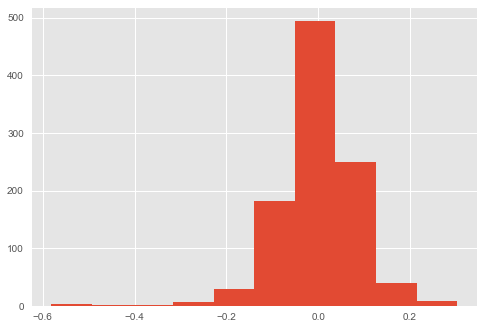

In [34]:
residuals = np.log(trainYcp) - ridge_base32.predict(trainXcp_trans)
plt.hist(residuals)

- Numerical columns are not standardized and normalization is not turned on

(array([  3.,   2.,   1.,   7.,  30., 181., 494., 250.,  40.,   9.]),
 array([-0.58154168, -0.49309903, -0.40465638, -0.31621373, -0.22777108,
        -0.13932842, -0.05088577,  0.03755688,  0.12599953,  0.21444218,
         0.30288484]),
 <BarContainer object of 10 artists>)

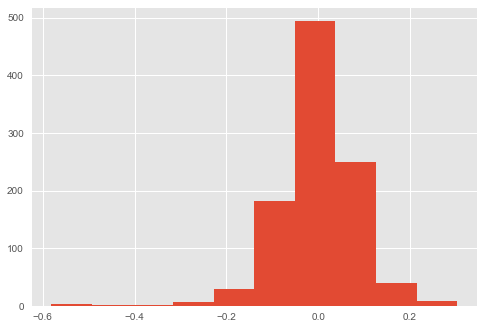

In [35]:
residuals = np.log(trainY) - ridge_base31.predict(trainX_trans)
plt.hist(residuals)

- Numerical columns are not standardized and normalization is turned on

(array([  4.,   3.,   6.,  21.,  75., 379., 393., 112.,  19.,   5.]),
 array([-0.62770214, -0.52319837, -0.4186946 , -0.31419083, -0.20968706,
        -0.10518329, -0.00067952,  0.10382425,  0.20832802,  0.31283179,
         0.41733556]),
 <BarContainer object of 10 artists>)

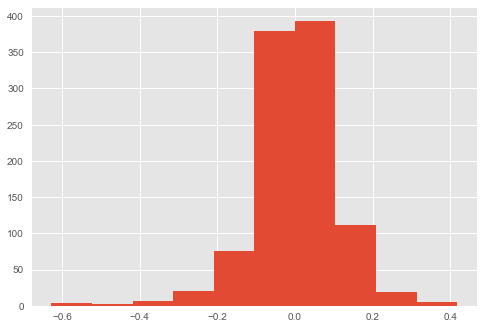

In [36]:
residuals = np.log(trainY) - ridge_base33.predict(trainX_trans)
plt.hist(residuals)

## Investigating alpha levels for model with numerical columns not standardized and normalization turned on:

In [37]:
alphas = np.arange(0,20)
scores = []

for alpha in alphas:
        ridge_base32.set_params(alpha=alpha)
        ridge_base32.fit(trainXcp_trans, np.log(trainYcp))  
        scores.append(ridge_base32.score(trainXcp_trans, np.log(trainYcp)))

Text(0, 0.5, '$R^2$')

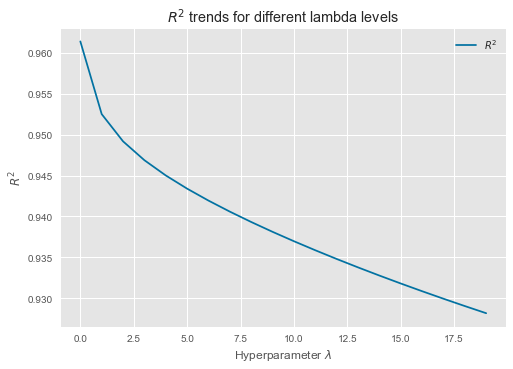

In [38]:
plt.plot(alphas, scores, c='b', label=r'$R^2$')
plt.legend(loc=1)
plt.title(r'$R^2$ trends for different lambda levels')
plt.xlabel(r'Hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

## Investigating alpha levels for model with numerical columns not standardized and normalization turned on:

In [39]:
alphas = np.arange(0,20)
ridge_base33.set_params(normalize=True)
scores = []

for alpha in alphas:
        ridge_base33.set_params(alpha=alpha)
        ridge_base33.fit(trainX_trans, np.log(trainY))  
        scores.append(ridge_base33.score(trainX_trans, np.log(trainY)))

Text(0, 0.5, '$R^2$')

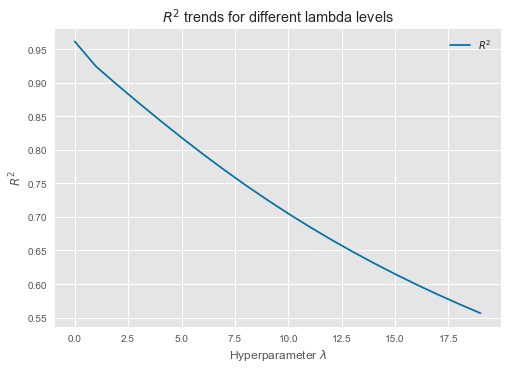

In [40]:
plt.plot(alphas, scores, c='b', label=r'$R^2$')
plt.legend(loc=1)
plt.title(r'$R^2$ trends for different lambda levels')
plt.xlabel(r'Hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

## Using Grid Search CV to fing the optimum alpha:

In [41]:
ridge_final_1 = ridge_base31
ridge_final_2 = ridge_base33.set_params(normalize=True)

In [42]:
# Creating parameter list to search for different alphas
paramDict = {'alpha': np.linspace(0.01,100,10)}

# Initiating the Grid Search
grid1 = GridSearchCV(ridge_final_1, paramDict, cv=5, return_train_score = True)

# Fitting the grid object
ans_ridge1 = grid1.fit(trainX_trans, np.log(trainY))

In [43]:
## The best parameter is
ans_ridge1.best_params_

{'alpha': 11.12}

In [44]:
## The best score is
ans_ridge1.best_score_

0.9066357282957235

In [45]:
# Creating parameter list to search for different alphas
paramDict = {'alpha': np.linspace(0.01,100,10)}

# Initiating the Grid Search
grid2 = GridSearchCV(ridge_final_2, paramDict, cv=5, return_train_score = True)

# Fitting the grid object
ans_ridge2 = grid2.fit(trainX_trans, np.log(trainY))

In [46]:
## The best parameter is
ans_ridge2.best_params_

{'alpha': 0.01}

In [47]:
## The best score is
ans_ridge2.best_score_

0.8379218324579878

## Final Ridge Regression models:

In [48]:
# Numerical columns not standardized (normalization is not turned on):

ridge_fin1 = Ridge()
ridge_fin1.set_params(alpha=11.12)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), ridge_fin1, show = True)

Train R^2 is equal to 0.936
Test R^2 is equal to 0.906
The intercept is 6.646
RSS is equal to 10.396
Train RMSE is equal to 0.101
Test RMSE is equal to 0.119
The training error is: 0.06426
The test     error is: 0.09359


[0.0642576402131283, 0.09358645795023013]

(array([  3.,   2.,   6.,  13.,  69., 277., 492., 127.,  25.,   3.]),
 array([-0.62296224, -0.52218726, -0.42141228, -0.3206373 , -0.21986232,
        -0.11908735, -0.01831237,  0.08246261,  0.18323759,  0.28401257,
         0.38478755]),
 <BarContainer object of 10 artists>)

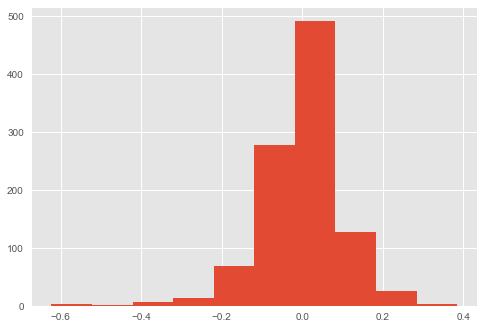

In [49]:
# Plotting the residuals

residuals = np.log(trainY) - ridge_fin1.predict(trainX_trans)
plt.hist(residuals)

In [50]:
# Numerical columns not standardized (normalization is turned on):

ridge_fin2 = Ridge()
ridge_fin2.set_params(alpha=0.01, normalize=True)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), ridge_fin2, show = True)

Train R^2 is equal to 0.960
Test R^2 is equal to 0.854
The intercept is 5.100
RSS is equal to 6.533
Train RMSE is equal to 0.080
Test RMSE is equal to 0.149
The training error is: 0.04038
The test     error is: 0.14595


[0.04038178337388432, 0.14595094076604853]

(array([  2.,   3.,   1.,   4.,  30., 168., 459., 278.,  63.,   9.]),
 array([-0.54492755, -0.46310112, -0.38127469, -0.29944827, -0.21762184,
        -0.13579541, -0.05396898,  0.02785745,  0.10968388,  0.1915103 ,
         0.27333673]),
 <BarContainer object of 10 artists>)

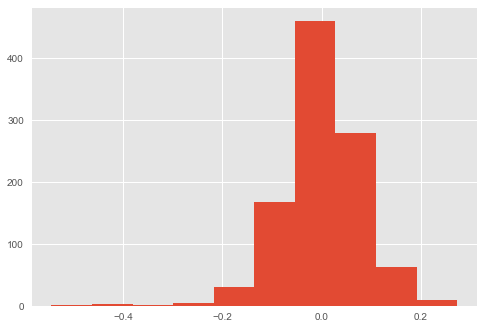

In [51]:
# Plotting the residuals

residuals = np.log(trainY) - ridge_fin2.predict(trainX_trans)
plt.hist(residuals)

## Lasso Regression Models:-

In [52]:
## Separating x and y variables for test-train split (main df)

house_x = train_df.drop(['SalePrice'], axis=1)
house_y = train_df['SalePrice']

## Separating x and y variables for test-train split (copy df)

house_x_cpy = train_df_cpy.drop(['SalePrice'], axis=1)
house_y_cpy = train_df_cpy['SalePrice']

# Train test 70:30 split

trainX, testX, trainY, testY = train_test_split(house_x, house_y, random_state=42, test_size=0.3)
trainXcp, testXcp, trainYcp, testYcp = train_test_split(house_x_cpy, house_y_cpy, random_state=42, test_size=0.3)

### 1. Adjusting standardization/normalisation and alpha levels

In [53]:
# Numerical columns standardized:

lasso_base12 = Lasso()
model_results(trainXcp, trainYcp, testXcp, testYcp, lasso_base12, show = True)

Train R^2 is equal to 0.950
Test R^2 is equal to 0.836
The intercept is -206245.078
RSS is equal to 309639117589.085
Train RMSE is equal to 17448.875
Test RMSE is equal to 29604.028
The training error is: 0.04984
The test     error is: 0.16371


[0.04984050040822585, 0.1637122028890894]

In [54]:
# Numerical columns not standardized (normalization is not turned on):

lasso_base11 = Lasso()
model_results(trainX, trainY, testX, testY, lasso_base11, show = True)

Train R^2 is equal to 0.950
Test R^2 is equal to 0.836
The intercept is -206245.078
RSS is equal to 309639117589.085
Train RMSE is equal to 17448.875
Test RMSE is equal to 29604.028
The training error is: 0.04984
The test     error is: 0.16371


[0.04984050040822585, 0.1637122028890894]

In [55]:
# Numerical columns not standardized (normalization is turned on):

lasso_base13 = Lasso()
lasso_base13.set_params(normalize=True)
model_results(trainX, trainY, testX, testY, lasso_base13, show = True)

Train R^2 is equal to 0.949
Test R^2 is equal to 0.850
The intercept is -170145.133
RSS is equal to 314142596934.360
Train RMSE is equal to 17575.308
Test RMSE is equal to 28349.727
The training error is: 0.05057
The test     error is: 0.15013


[0.050565394813991804, 0.15013336009747036]

In [56]:
# Numerical columns not standardized (normalization is turned on and alpha set to 0):

lasso_base24 = Lasso()
lasso_base24.set_params(alpha = 0, normalize=True)
model_results(trainX, trainY, testX, testY, ridge_base24, show = True)

Train R^2 is equal to 0.950
Test R^2 is equal to -323454092875873241792512.000
The intercept is -222896591188807168.000
RSS is equal to 309087089278.000
Train RMSE is equal to 17433.314
Test RMSE is equal to 41611809415801728.000
The training error is: 0.04975
The test     error is: 323454092875873241792512.00000


[0.04975164416978228, 3.2345409287587324e+23]

### 2. Log-transforming y variable only:

In [57]:
# Numerical columns standardized:

lasso_base22 = Lasso()
model_results(trainXcp, np.log(trainYcp), testXcp, np.log(testYcp), lasso_base22, show = True)

Train R^2 is equal to 0.820
Test R^2 is equal to 0.819
The intercept is 11.116
RSS is equal to 29.131
Train RMSE is equal to 0.169
Test RMSE is equal to 0.166
The training error is: 0.18006
The test     error is: 0.18071


[0.18006345322461814, 0.18070563768710968]

In [58]:
# Numerical columns not standardized (normalization is not turned on):

lasso_base21 = Lasso()
model_results(trainX, np.log(trainY), testX, np.log(testY), lasso_base21, show = True)

Train R^2 is equal to 0.820
Test R^2 is equal to 0.819
The intercept is 11.116
RSS is equal to 29.131
Train RMSE is equal to 0.169
Test RMSE is equal to 0.166
The training error is: 0.18006
The test     error is: 0.18071


[0.18006345322461814, 0.18070563768710968]

In [59]:
# Numerical columns not standardized (normalization is turned on):

lasso_base23 = Lasso()
lasso_base23.set_params(normalize=True)
model_results(trainX, np.log(trainY), testX, np.log(testY), lasso_base23, show = True)

Train R^2 is equal to 0.000
Test R^2 is equal to -0.002
The intercept is 12.028
RSS is equal to 161.781
Train RMSE is equal to 0.399
Test RMSE is equal to 0.390
The training error is: 1.00000
The test     error is: 1.00246


[1.0, 1.0024630833253119]

In [60]:
# Numerical columns not standardized (normalization is turned on and alpha set to 0):

lasso_base24 = Lasso()
lasso_base24.set_params(alpha = 0, normalize=True)
model_results(trainX, np.log(trainY), testX, np.log(testY), lasso_base24, show = True)

Train R^2 is equal to 0.963
Test R^2 is equal to 0.823
The intercept is 9.377
RSS is equal to 6.059
Train RMSE is equal to 0.077
Test RMSE is equal to 0.164
The training error is: 0.03745
The test     error is: 0.17688


[0.03745258602604373, 0.17687540708190386]

### 3. Log-transforming x and y variables:

In [61]:
# Applying log-transformation on the x features (both datasets)

trfm = FunctionTransformer(func=np.log1p)

trainX_trans = trfm.fit_transform(trainX)
trainXcp_trans = trfm.fit_transform(trainXcp)
testX_trans = trfm.fit_transform(testX)
testXcp_trans = trfm.fit_transform(testXcp)

In [62]:
# Numerical columns standardized:

lasso_base32 = Lasso()
model_results(trainXcp_trans, np.log(trainYcp), testXcp_trans, np.log(testYcp), lasso_base32, show = True)

Train R^2 is equal to 0.000
Test R^2 is equal to -0.002
The intercept is 12.028
RSS is equal to 161.781
Train RMSE is equal to 0.399
Test RMSE is equal to 0.390
The training error is: 1.00000
The test     error is: 1.00246


[1.0, 1.0024630833253119]

In [63]:
# Numerical columns not standardized (normalization is not turned on):

lasso_base31 = Lasso()
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), lasso_base31, show = True)

Train R^2 is equal to 0.000
Test R^2 is equal to -0.002
The intercept is 12.028
RSS is equal to 161.781
Train RMSE is equal to 0.399
Test RMSE is equal to 0.390
The training error is: 1.00000
The test     error is: 1.00246


[1.0, 1.0024630833253119]

In [64]:
# Numerical columns not standardized (normalization is turned on):

lasso_base33 = Lasso()
lasso_base33.set_params(normalize=True)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), lasso_base33, show = True)

Train R^2 is equal to 0.000
Test R^2 is equal to -0.002
The intercept is 12.028
RSS is equal to 161.781
Train RMSE is equal to 0.399
Test RMSE is equal to 0.390
The training error is: 1.00000
The test     error is: 1.00246


[1.0, 1.0024630833253119]

In [65]:
# Numerical columns not standardized (normalization is turned on and alpha set to 0):

lasso_base34 = Lasso()
lasso_base34.set_params(alpha = 0, normalize=True)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), lasso_base34, show = True)

Train R^2 is equal to 0.961
Test R^2 is equal to 0.782
The intercept is 4.142
RSS is equal to 6.244
Train RMSE is equal to 0.078
Test RMSE is equal to 0.182
The training error is: 0.03860
The test     error is: 0.21798


[0.03859675455848166, 0.2179774840481964]

## Investigating alpha levels for model with numerical columns not standardized and normalization turned on:

In [66]:
alphas = np.arange(0,20)
lasso_base34.set_params(normalize=True)
scores = []

for alpha in alphas:
        lasso_base34.set_params(alpha=alpha)
        lasso_base34.fit(trainX_trans, np.log(trainY))  
        scores.append(lasso_base34.score(trainX_trans, np.log(trainY)))

Text(0, 0.5, '$R^2$')

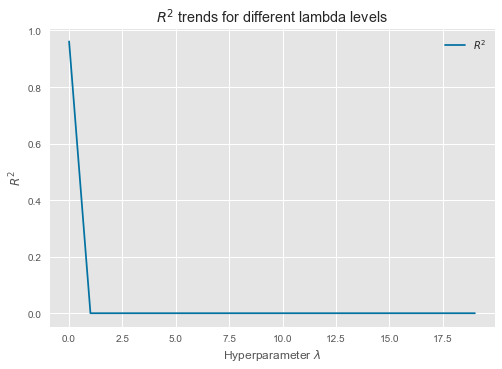

In [67]:
plt.plot(alphas, scores, c='b', label=r'$R^2$')
plt.legend(loc=1)
plt.title(r'$R^2$ trends for different lambda levels')
plt.xlabel(r'Hyperparameter $\lambda$')
plt.ylabel(r'$R^2$')

## Using Grid Search CV to fing the optimum alpha:

In [68]:
# Model object created
lasso_final = lasso_base34.set_params(normalize=True)

In [69]:
# Creating parameter list to search for different alphas
paramDict = {'alpha': np.linspace(0,2,20)}

# Initiating the Grid Search
grid = GridSearchCV(lasso_final, paramDict, cv=5, return_train_score = True)

# Fitting the grid object
ans_lasso = grid.fit(trainX_trans, np.log(trainY))

In [70]:
## The best parameter is
ans_lasso.best_params_

{'alpha': 0.0}

In [71]:
## The best score is
ans_lasso.best_score_

0.7828469581183591

## Final Lasso Regression model:

In [72]:
# Numerical columns not standardized (normalization is not turned on):

lasso_fin = Lasso()
lasso_fin.set_params(alpha=0.0003, normalize=True)
model_results(trainX_trans, np.log(trainY), testX_trans, np.log(testY), lasso_fin, show = True)

Train R^2 is equal to 0.920
Test R^2 is equal to 0.900
The intercept is 6.091
RSS is equal to 13.014
Train RMSE is equal to 0.113
Test RMSE is equal to 0.123
The training error is: 0.08044
The test     error is: 0.09959


[0.08043936879130809, 0.09959030156268234]

(array([  3.,   1.,   3.,   9.,  40., 146., 503., 260.,  46.,   6.]),
 array([-0.756203  , -0.64131534, -0.52642768, -0.41154002, -0.29665236,
        -0.1817647 , -0.06687704,  0.04801062,  0.16289828,  0.27778594,
         0.3926736 ]),
 <BarContainer object of 10 artists>)

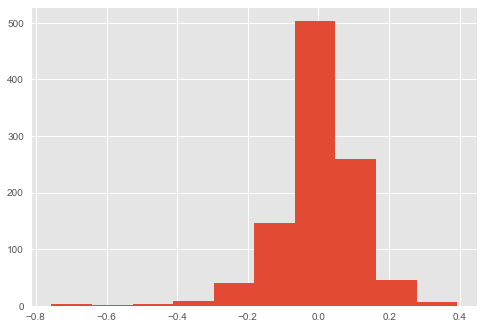

In [73]:
# Plotting the residuals

residuals = np.log(trainY) - lasso_fin.predict(trainX_trans)
plt.hist(residuals)

## Lasso important features

- Lasso Coefficients

In [74]:
lassoCoef = pd.Series(lasso_fin.coef_, index=house_x.columns)
print('The slopes are \n %s' %(lassoCoef))

The slopes are 
 LotFrontage              0.000000
LotArea                  0.076303
LotShape                -0.000000
LandSlope                0.000000
OverallQual              0.415315
                           ...   
SaleCondition_Alloca     0.000000
SaleCondition_Family    -0.026409
SaleCondition_Normal     0.009372
SaleCondition_Partial    0.000000
remod_y_n_Y              0.000000
Length: 436, dtype: float64


- Lasso Coefficients sorted

In [75]:
sortedCoefs = lassoCoef.sort_values(ascending=False)
sortedCoefs

Usable_Space            0.443220
OverallQual             0.415315
OverallCond             0.221951
GarageCars              0.115114
Neighborhood_Crawfor    0.084243
                          ...   
Neighborhood_OldTown   -0.054037
Functional_Maj2        -0.062904
ExterQual              -0.063655
GarageYrBlt_1920       -0.150783
KitchenAbvGr           -0.152025
Length: 436, dtype: float64

In [76]:
# Looking at top 15
pd.DataFrame(sortedCoefs, columns=['Lasso coefficients']).head(15)

,Lasso coefficients
Usable_Space,0.443220
OverallQual,0.415315
OverallCond,0.221951
GarageCars,0.115114
Neighborhood_Crawfor,0.084243
1stFlrSF,0.082151
LotArea,0.076303
RoofMatl_WdShngl,0.072155
Functional_Typ,0.069707
Neighborhood_NoRidge,0.054527


- Another way to select coefficients

In [77]:
feature_sel_model = SelectFromModel(Lasso(alpha=0.0003, normalize=True, random_state=42))
feature_sel_model.fit(trainX_trans, np.log(trainY))

SelectFromModel(estimator=Lasso(alpha=0.0003, normalize=True, random_state=42))

In [78]:
selected_feat = trainX_trans.columns[(feature_sel_model.get_support())]
selected_feat

Index(['LotArea', 'OverallQual', 'OverallCond', 'ExterQual', 'BsmtQual',
       'BsmtCond', 'BsmtUnfSF', 'HeatingQC', '1stFlrSF', 'KitchenAbvGr',
       'KitchenQual', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'sold_age', 'yr_since_remod', 'Total_Fullbaths', 'Usable_Space',
       'Condition1_Norm', 'Condition1_RRAe', 'LotConfig_CulDSac',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_IDOTRR',
       'Neighborhood_NoRidge', 'Neighborhood_OldTown', 'Neighborhood_StoneBr',
       'GarageYrBlt_1920', 'YearBuilt_1932', 'YearBuilt_2008',
       'YearRemodAdd_1977', 'YearRemodAdd_1997', 'YearRemodAdd_2008',
       'YearRemodAdd_2009', 'RoofMatl_WdShngl', 'Foundation_PConc',
       'CentralAir_Y', 'Functional_Maj2', 'Functional_Typ', 'GarageFinish_Unf',
       'PavedDrive_Y', 'SaleCondition_Family', 'SaleCondition_Normal'],
      dtype='object')

# Visualizing results

## Final Ridge Regression model:

- Residual plots:

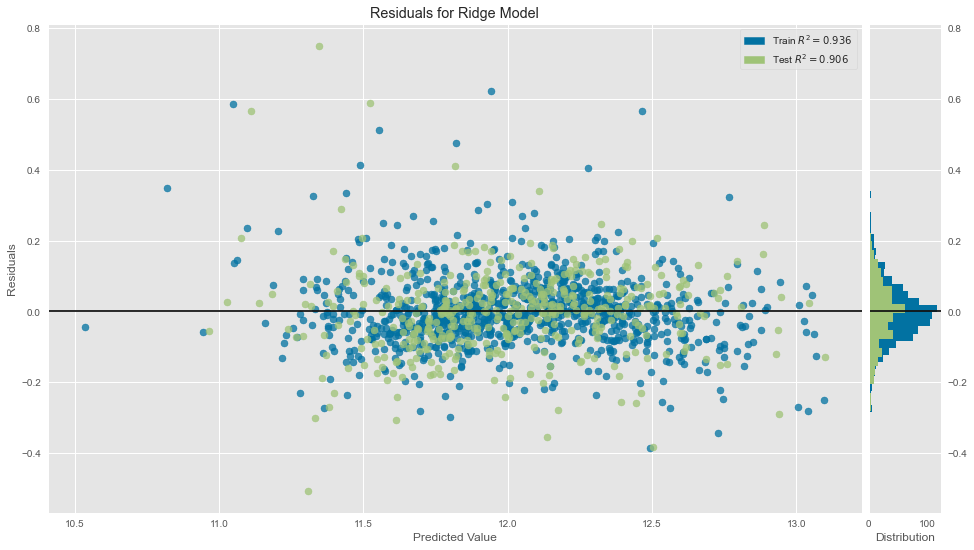

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [79]:
plt.figure(figsize = (16,9))
visualizer2 = ResidualsPlot(ridge_fin1.set_params(alpha=11.12))
visualizer2.fit(trainX_trans, np.log(trainY))
visualizer2.score(testX_trans, np.log(testY))
visualizer2.poof()

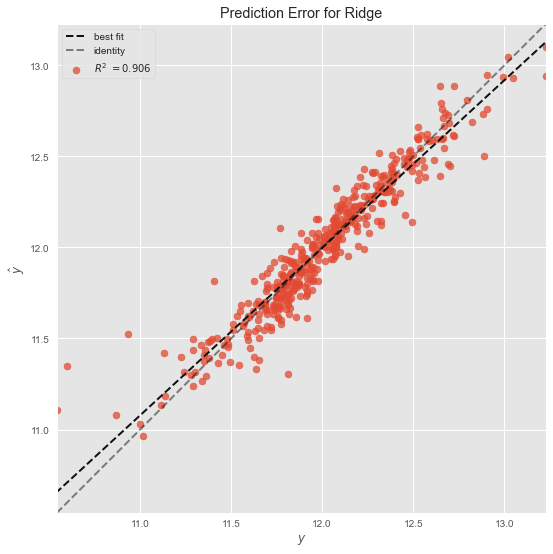

<AxesSubplot:title={'center':'Prediction Error for Ridge'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [80]:
plt.figure(figsize = (16,9))
visualizer2 = PredictionError(ridge_fin1.set_params(alpha=11.12))
visualizer2.fit(trainX_trans, np.log(trainY))
visualizer2.score(testX_trans, np.log(testY))
visualizer2.poof()

## Final Lasso Regression model:

- Residual plots:

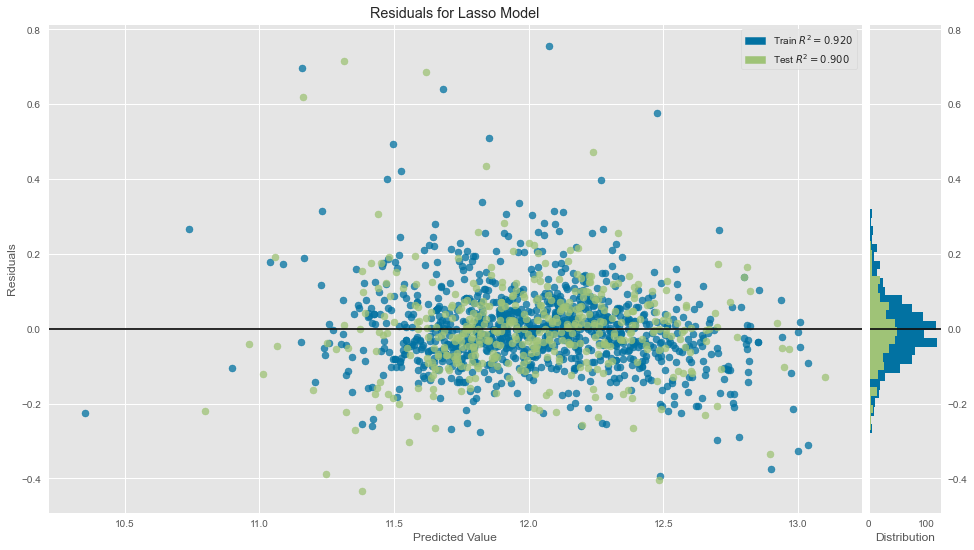

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [81]:
plt.figure(figsize = (16,9))
visualizer4 = ResidualsPlot(lasso_fin.set_params(alpha=0.0003, normalize=True))
visualizer4.fit(trainX_trans, np.log(trainY))
visualizer4.score(testX_trans, np.log(testY))
visualizer4.poof()

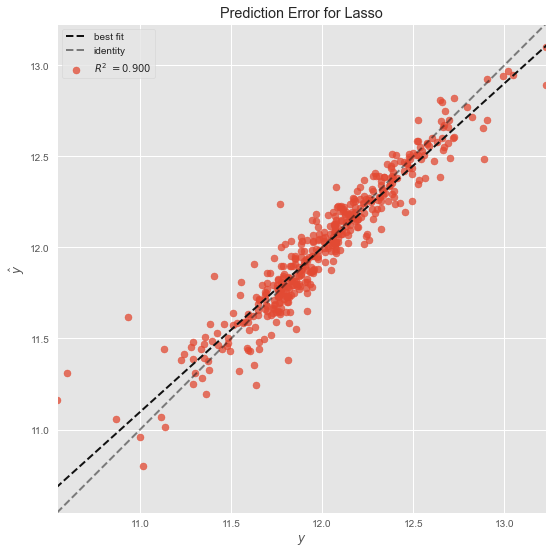

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [82]:
plt.figure(figsize = (16,9))
visualizer2 = PredictionError(lasso_fin.set_params(alpha=0.0003, normalize=True))
visualizer2.fit(trainX_trans, np.log(trainY))
visualizer2.score(testX_trans, np.log(testY))
visualizer2.poof()

## Final Ridge Regression model:

- Residual plots:

In [83]:
# Creating columns needed for assumption graphs:

ridge_fin = Ridge()
ridge_fin = ridge_fin1.set_params(alpha=11.12)

trainX['house_sales_pred'] = ridge_fin.predict(trainX_trans)
trainX['actual_sales'] = np.log(trainY)
trainX['residual'] = trainX['actual_sales'] - trainX['house_sales_pred']

<Figure size 1440x1440 with 0 Axes>

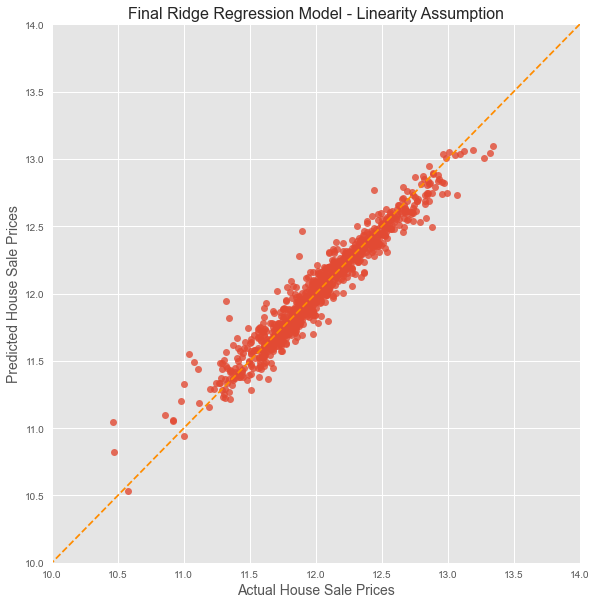

In [84]:
# Plotting the observed vs predicted values

plt.figure(figsize=(20, 20))
sns.lmplot(x='actual_sales', y='house_sales_pred', data=trainX, palette="Set2", fit_reg=False, size=8)
    
# Plotting the diagonal line

line_coords = np.arange(trainX[['actual_sales', 'house_sales_pred']].min().min()-2, 
                        trainX[['actual_sales', 'house_sales_pred']].max().max()+2)
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')

# Labeling and graph adjustment

plt.ylabel('Predicted House Sale Prices', fontsize=14)
plt.xlabel('Actual House Sale Prices', fontsize=14)
plt.title('Final Ridge Regression Model - Linearity Assumption', fontsize=16)
plt.xlim(10, 14)
plt.ylim(10, 14)
plt.show()

In [85]:
# Performing the Anderson- Darling test on the residuals

p_value = normal_ad(trainX['residual'])[1]
print('p-value from the test Anderson-Darling test below 0.05 generally means non-normal:', p_value)

p-value from the test Anderson-Darling test below 0.05 generally means non-normal: 5.128608959287112e-29


## Final Lasso Regression model:

- Residual plots:

In [86]:
# Creating columns needed for assumption graphs:

trainX['house_sales_pred'] = lasso_fin.predict(trainX_trans)
trainX['actual_sales'] = np.log(trainY)
trainX['residual'] = trainX['actual_sales'] - trainX['house_sales_pred']

<Figure size 1440x1440 with 0 Axes>

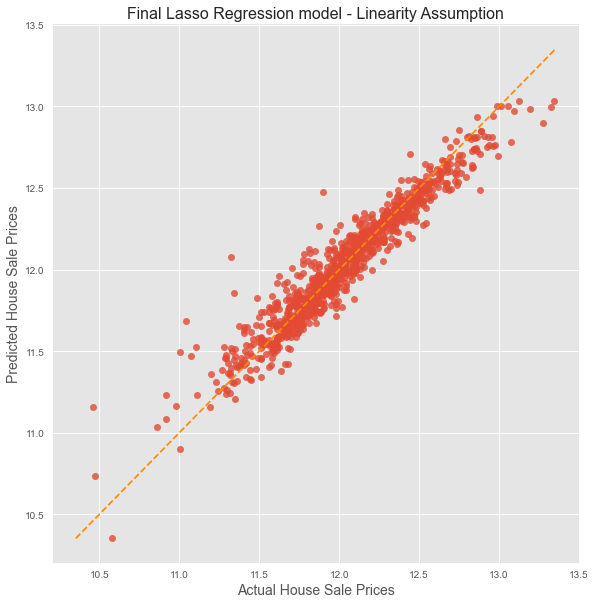

In [87]:
# Plotting the observed vs predicted values

plt.figure(figsize=(20, 20))
sns.lmplot(x='actual_sales', y='house_sales_pred', data=trainX, palette="Set2", fit_reg=False, size=8)
    
# # Plotting the diagonal line

line_coords = np.arange(trainX[['actual_sales', 'house_sales_pred']].min().min(), 
                        trainX[['actual_sales', 'house_sales_pred']].max().max()+1)
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')

# Labeling and graph adjustment

plt.ylabel('Predicted House Sale Prices', fontsize=14)
plt.xlabel('Actual House Sale Prices', fontsize=14)
plt.title('Final Lasso Regression model - Linearity Assumption', fontsize=16)
plt.show()

In [88]:
# Performing the Anderson- Darling test on the residuals

p_value = normal_ad(trainX['residual'])[1]
print('p-value from the test Anderson-Darling test below 0.05 generally means non-normal:', p_value)

p-value from the test Anderson-Darling test below 0.05 generally means non-normal: 8.650357585995063e-31
